# __Forecasting Average Length of Stay (ALOS) in U.S. Hospitals Using Seasonal Indexing and Linear Regression.__

## __Project Overview__

The primary aim of this project is to analyze the **Average Length of Stay (ALOS)** in hospitals and forecast future trends. By leveraging the historical data of inpatient days and hospital discharges, this project seeks to understand trends in ALOS data to investigate the effect of seasonal diseases like flu, respiratory illness, etc; and finally to forecast the future ALOS values. This analysis will help in making informed decisions regarding capacity planning, resource allocation, and operational efficiency in healthcare settings.

The project utilizes two key datasets:
1. **Total Inpatient Days for Hospitals** (2005–2022)
2. **Total Discharges for Hospitals** (2005–2022)

The ALOS is derived from these datasets by calculating the ratio of inpatient days to discharges for each time period.

#### __Import the required libraries.__

In [26]:
import os
import json
import requests
import fredapi as fd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from dotenv import load_dotenv
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
import warnings
warnings.filterwarnings('ignore')

## __Data Extraction__

#### __Lets create a class that will interact with the FRED (Federal Reserve Economic Data) API to extract the required dataset.__

In [2]:
load_dotenv()
class fredapi:
    
    def __init__(self, token=None):
        self.token=token
        self.url="https://api.stlouisfed.org/fred/series/observations?series_id={seriesid}&api_key={key}&file_type=json"
        
    def set_token(self, token):
        self.token=token
        
    def get_series(self, seriesid):
        if not self.token:
            raise Exception("You did not specify an API key.")
        url_formatted=self.url.format(seriesid=seriesid, key=self.token)
        response=requests.get(url_formatted)
        
        if response.status_code==200:
            jsondata=response.json()
            observations=jsondata.get('observations',[])
            data=pd.DataFrame(observations)
            if not data.empty:
                print("Available columns: ", data.columns.to_list())
                return data
        else:
            raise Exception("Bad response from API, status code={}".format(response.status_code))

#### __To understand the patient overflow over the years till recent quarters, let's extract Inpatient data and Total Discharges. Although more data like patient detail, demography, region, etc; could help us to get more clarity and some additional details, those data are very sensitive and very hard to get hands on. So, we will investigate with the available dataset.__

In [3]:
fred = fredapi(token=os.getenv('fred_api'))
data = fred.get_series("INPAT622ALLEST176QNSA")
data=data.drop(['realtime_start', 'realtime_end'], axis=1)
data=data.rename(columns={'date':'Date','value':'Inpatient_days'})
data['Date']=pd.to_datetime(data['Date'])
data['Inpatient_days']=data['Inpatient_days'].astype(float)
data.info()

Available columns:  ['realtime_start', 'realtime_end', 'date', 'value']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            80 non-null     datetime64[ns]
 1   Inpatient_days  80 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.4 KB


## __Time Series EDA__

In [4]:
data0=data[~data["Date"].dt.year.isin([2004, 2024])]
data0.tail()

,Date,Inpatient_days
72,2022-10-01,56512.0
73,2023-01-01,56762.0
74,2023-04-01,55356.0
75,2023-07-01,55576.0
76,2023-10-01,56264.0


In [5]:
print(data0.isna().any())
print(data0.duplicated().any())

Date              False
Inpatient_days    False
dtype: bool
False


In [6]:
fred1 = fredapi(token=os.getenv('fred_api'))
data1 = fred.get_series("DISC622ALLEST176QNSA")
data1=data1.drop(['realtime_start', 'realtime_end'], axis=1)
data1=data1.rename(columns={'date':'Date','value':'Inpatient_days'})
data1['Date']=pd.to_datetime(data1['Date'])
data1['Inpatient_days']=data1['Inpatient_days'].astype(float)
data1

Available columns:  ['realtime_start', 'realtime_end', 'date', 'value']


,Date,Inpatient_days
0,2004-10-01,9750.0
1,2005-01-01,10145.0
2,2005-04-01,9847.0
3,2005-07-01,9734.0
4,2005-10-01,9560.0
...,...,...
75,2023-07-01,9060.0
76,2023-10-01,9218.0
77,2024-01-01,9338.0
78,2024-04-01,9360.0


In [7]:
data2=data1[~data1["Date"].dt.year.isin([2004, 2024])]
data2.tail()

,Date,Inpatient_days
72,2022-10-01,9100.0
73,2023-01-01,9028.0
74,2023-04-01,9018.0
75,2023-07-01,9060.0
76,2023-10-01,9218.0


#### __Let's try to understand the Inpatient days data distribution over the years by data visualization.__

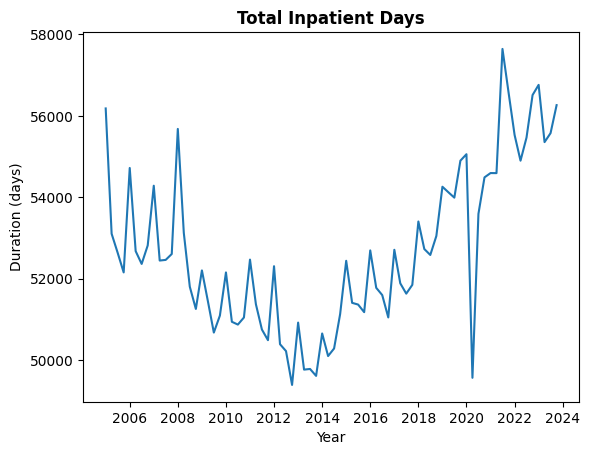

In [8]:
ipatient_duration=data0.set_index('Date')
plt.subplots()
plt.plot(ipatient_duration)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Duration (days)', fontsize=10)
plt.title('Total Inpatient Days', weight='bold', fontsize=12)
plt.show()

#### __Let's try to understand the Total Discharges data distribution over the years by data visualization.__

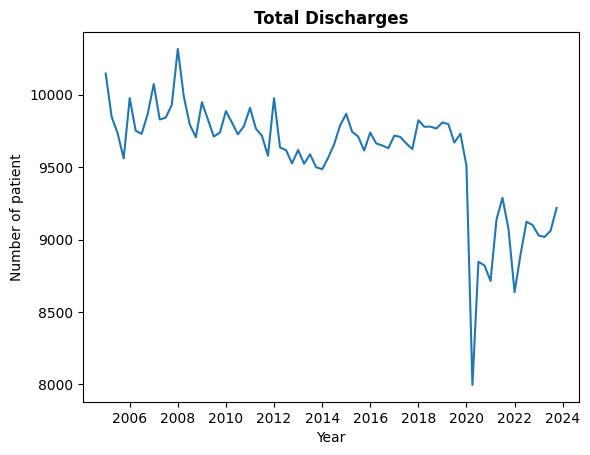

In [9]:
patient_discharge=data2.set_index('Date')
plt.subplots()
plt.plot(patient_discharge)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of patient', fontsize=10)
plt.title('Total Discharges', weight='bold', fontsize=12)
plt.show()

#### __Merging both the Total Inpatient dataset and Total Discharges dataset and calculating ALOS.__

In [10]:
df=pd.merge(ipatient_duration, patient_discharge, on='Date')
df['ALOS']=df['Inpatient_days_x']/df['Inpatient_days_y']
df

,Inpatient_days_x,Inpatient_days_y,ALOS
Date,,,
2005-01-01,56183.0,10145.0,5.537999
2005-04-01,53105.0,9847.0,5.393013
2005-07-01,52641.0,9734.0,5.407952
2005-10-01,52155.0,9560.0,5.455544
2006-01-01,54721.0,9976.0,5.485265
...,...,...,...
2022-10-01,56512.0,9100.0,6.210110
2023-01-01,56762.0,9028.0,6.287328
2023-04-01,55356.0,9018.0,6.138390


#### __Let's look for null values and duplicates.__

In [11]:
print(df.isna().any())
print(df.duplicated().any())

Inpatient_days_x    False
Inpatient_days_y    False
ALOS                False
dtype: bool
False


#### __Now, let's try to understand the ALOS data distribution over the years by data visualization.__

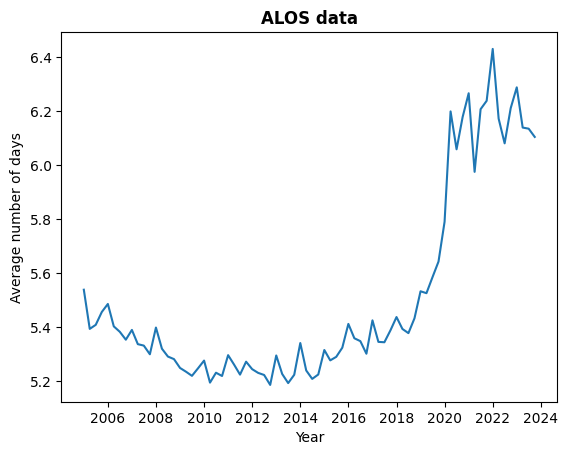

In [12]:
plt.subplots()
plt.plot(df['ALOS'])
plt.xlabel('Year', fontsize=10)
plt.ylabel('Average number of days', fontsize=10)
plt.title('ALOS data', weight='bold', fontsize=12)
plt.show()

##### <font color="green"> Now, one thing that is clearly visible from all three graphs (Inpatient, Total Dischage, and ALOS) is that there is a decrease in total discharge and Inpatient duration in 2020 because of lockdown, and after it there is a sudden increase; it is probably due to COVID. We can also observe in ALOS data that there is a sudden increase in the average number of days a patient stayed in the hospital in 2020 and after. </font>

#### __Now, we can investigate this dataset to understand if there is any pattern at any specific period over the years due to seasonal diseases like flu, RSV, common cold, etc. This can help the healthcare providers to properly utilize their resources and plan their operations.__

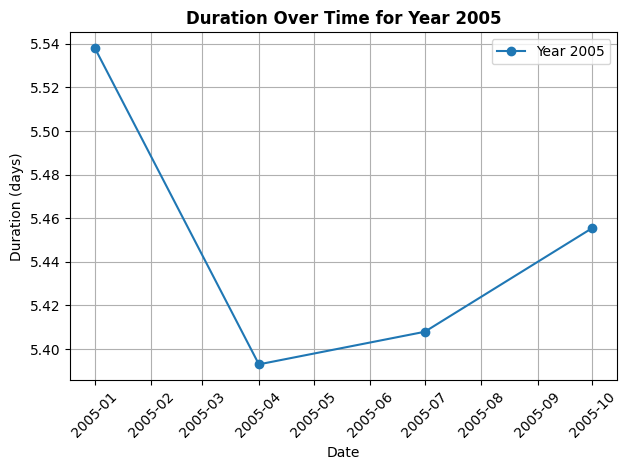

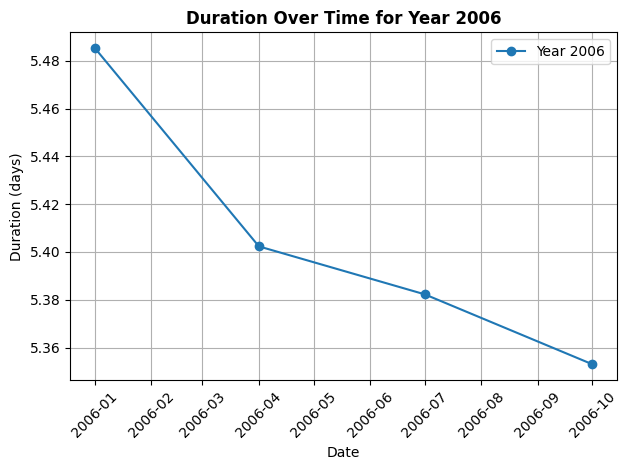

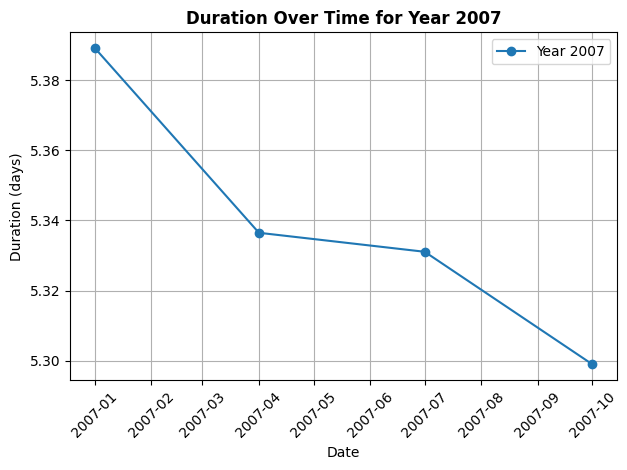

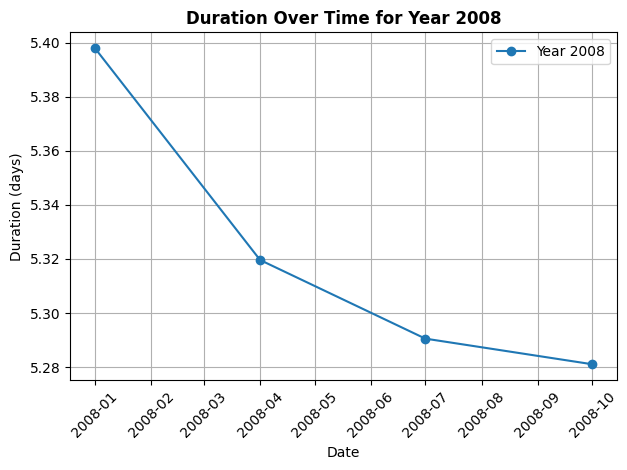

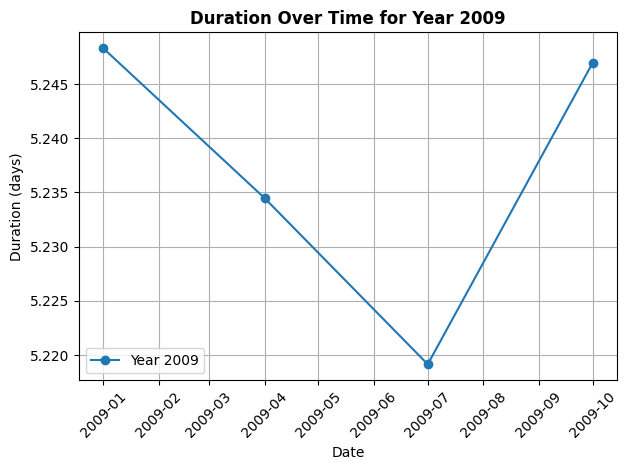

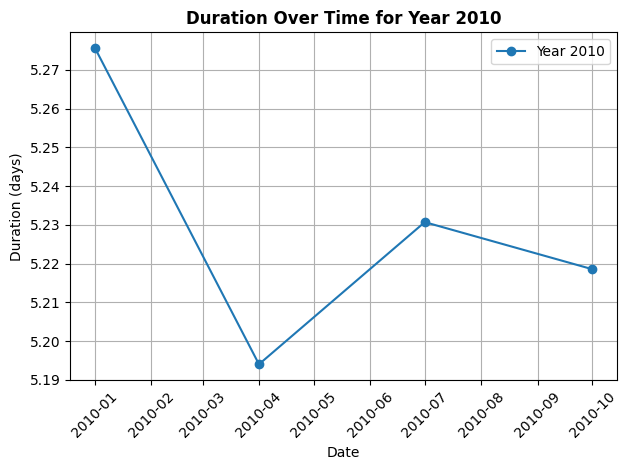

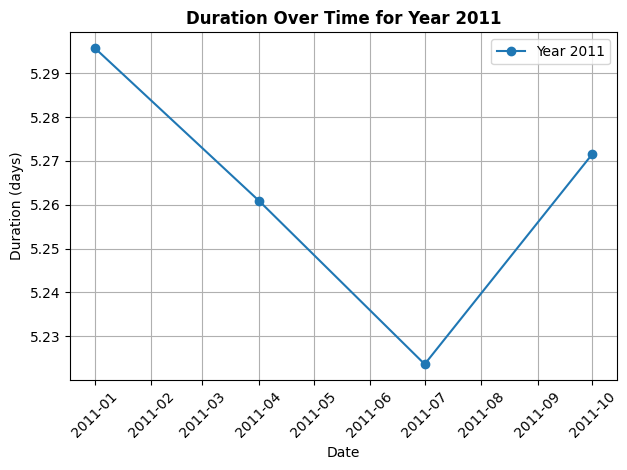

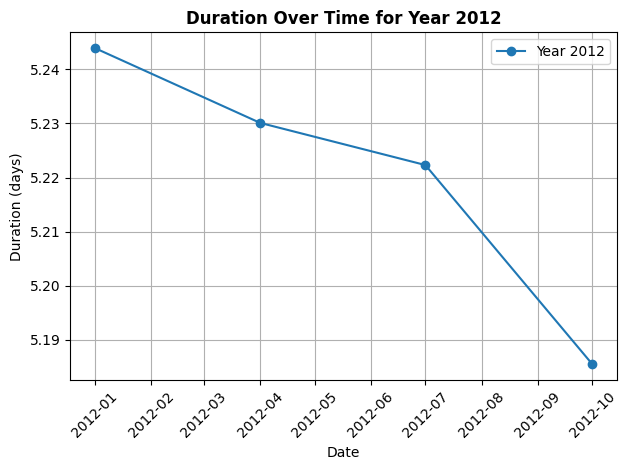

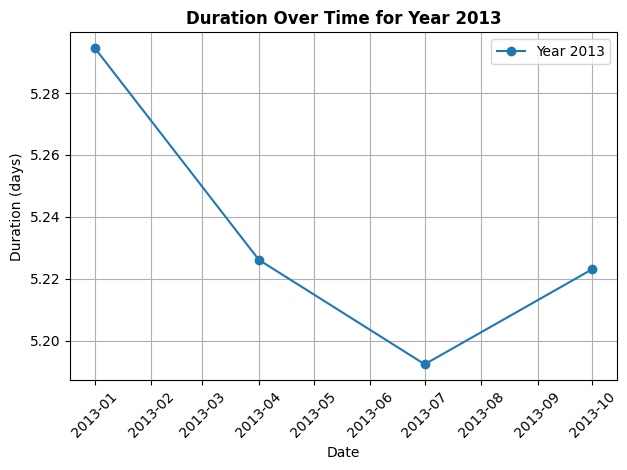

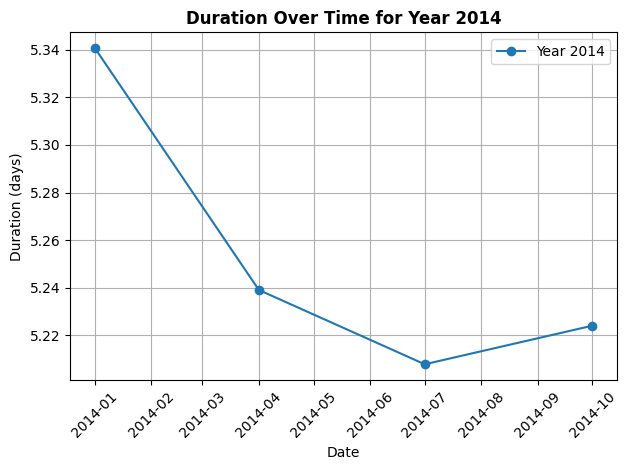

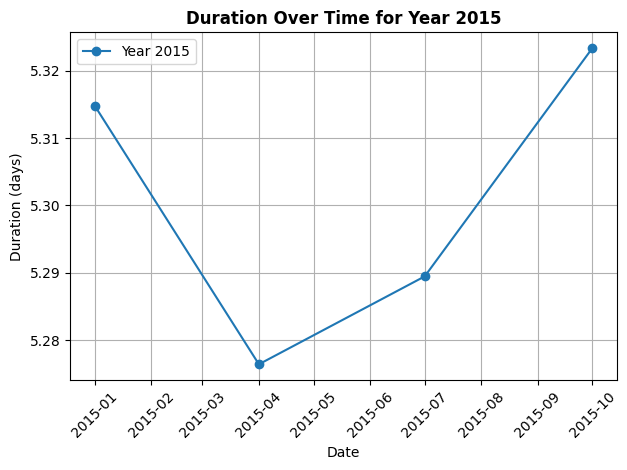

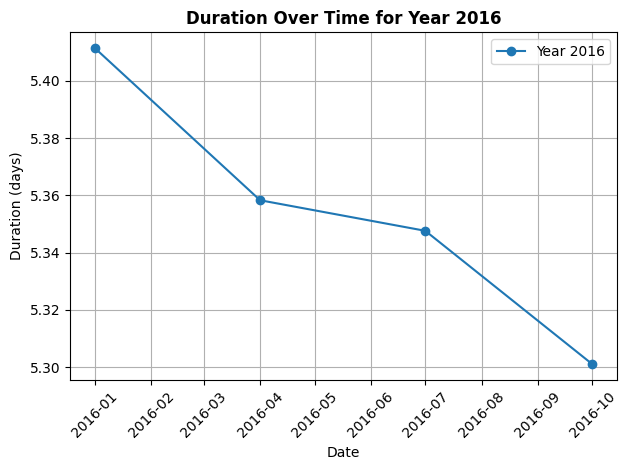

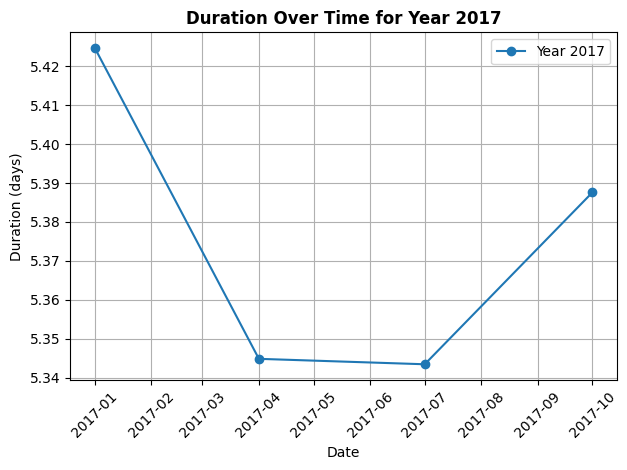

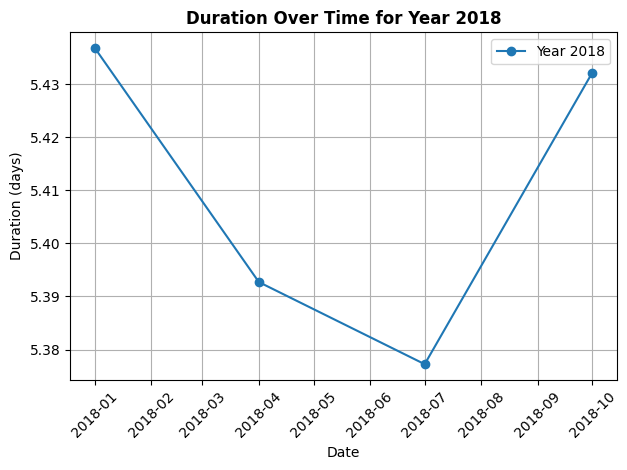

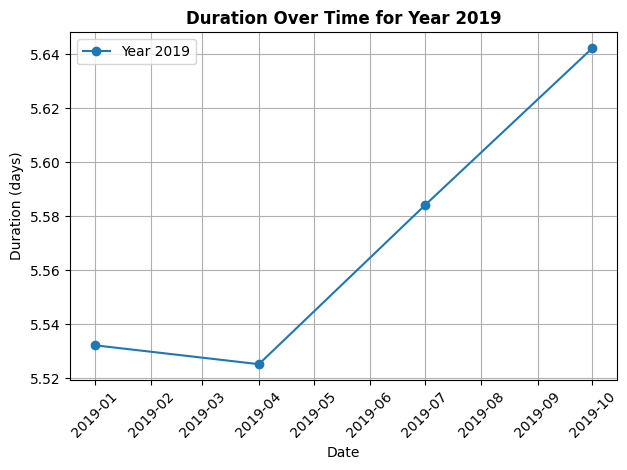

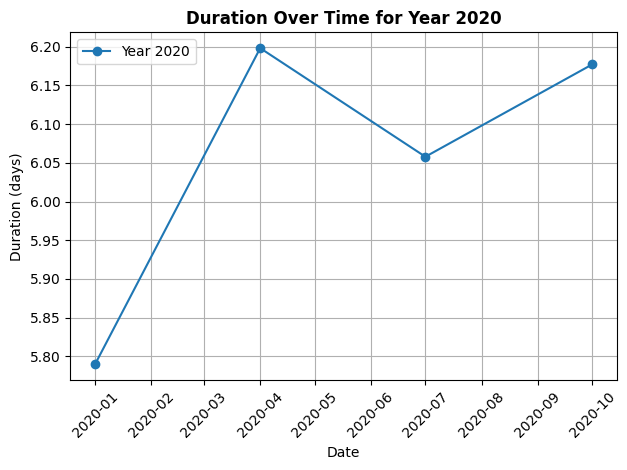

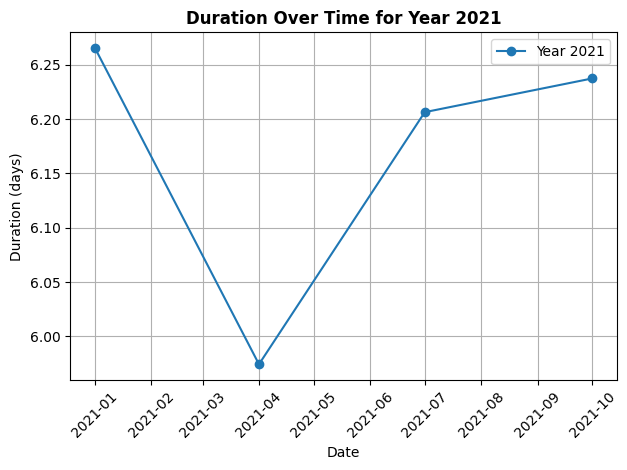

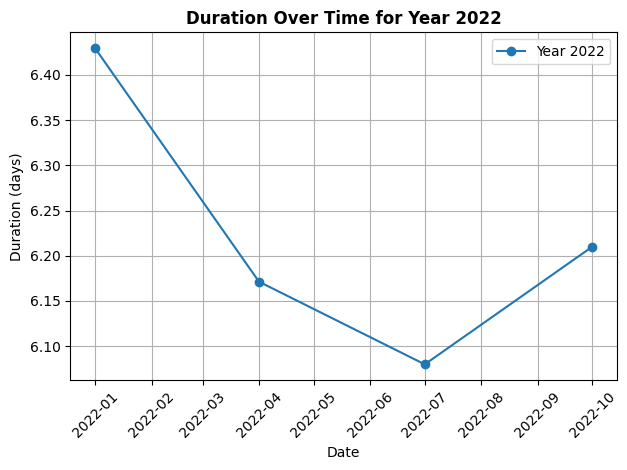

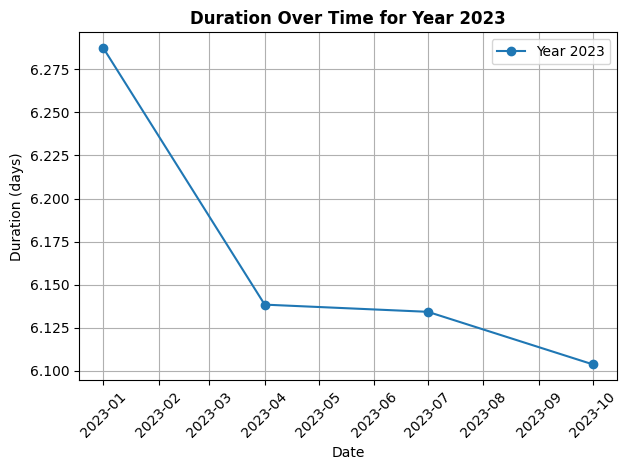

In [13]:
df["year"] = df.index.year
grouped = df.groupby("year")
for year, group in grouped:
    plt.figure()
    plt.plot(group.index, group["ALOS"], marker="o", linestyle="-", label=f"Year {year}")
    plt.title(f"Duration Over Time for Year {year}", weight='bold', fontsize=12)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Duration (days)", fontsize=10)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout() 
    plt.show()

##### <font color="green">Upon analyzing the dataset on a yearly basis, we observed peak points in the first quarter and occasionally in the last quarter. Seasonal diseases such as influenza, RSV, common cold, etc; typically emerge in the fall and winter, leading to an increase in patient admissions to the hospital. </font>

#### __Lets plot the seasonality to understand the seasonal variation of the ALOS data.__

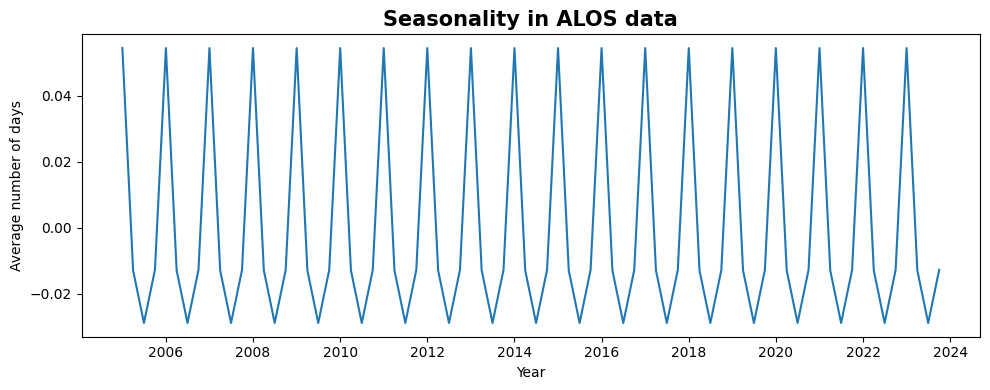

In [14]:
plt.figure(figsize=(10,4))
plt.plot(seasonal_decompose(df['ALOS']).seasonal)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Average number of days', fontsize=10)
plt.title('Seasonality in ALOS data', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

#### __So, the seasonality graph shows repetative and constant movement over the time; therefore, we can draw other components like Trend, Seasonality, and Residuals using Additive model to further understand our dataset.__

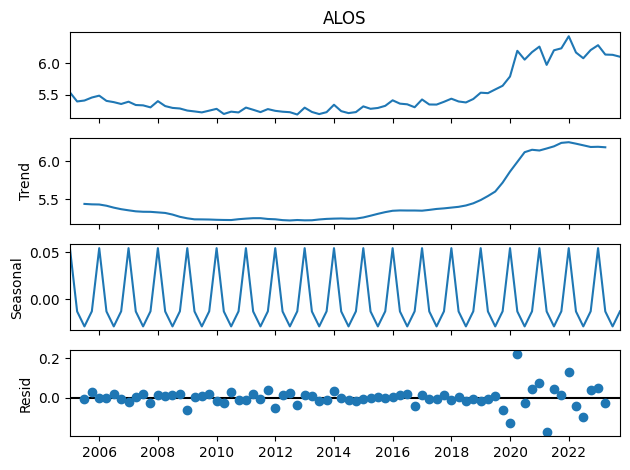

In [15]:
decomposition = seasonal_decompose(df['ALOS'], model='additive', period=4) #Adjust period
decomposition.plot()
plt.show()

#### __Now, let's investigate the Residuals to understand if there is any underlying pattern in our ALOS data.__

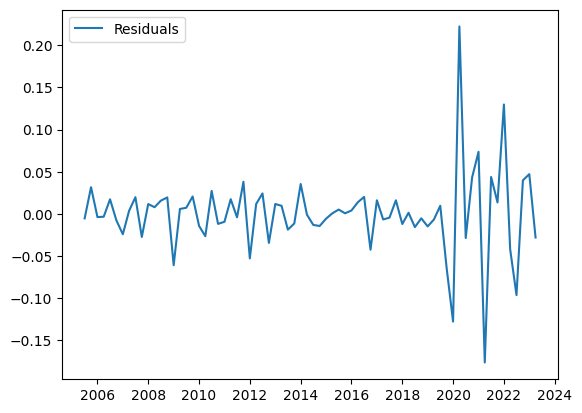

In [16]:
decompose=seasonal_decompose(df['ALOS'], model='additive', period=4)
plt.plot(decompose.resid, label='Residuals')
plt.legend()
plt.show()

##### <font color="green"> The above plot shows a random pattern of residuals, therefore confirming that the decomposition has successfully captured the underlying patterns in the ALOS data. </font>

## __Seasonal Indexing__

#### __Now, let's prepare the ALOS dataset for seasonal indexing to support the regression model for forecasting future values.__

In [17]:
res=df.drop(['Inpatient_days_x', 'Inpatient_days_y', 'year'], axis=1)
res_df=res[res.index.year!=2023]
res

,ALOS
Date,
2005-01-01,5.537999
2005-04-01,5.393013
2005-07-01,5.407952
2005-10-01,5.455544
2006-01-01,5.485265
...,...
2022-10-01,6.210110
2023-01-01,6.287328
2023-04-01,6.138390


#### __Calculate the average ALOS for each year.__

In [18]:
avg_ALOS=pd.DataFrame(res_df.groupby(res_df.index.year)['ALOS'].mean())
avg_ALOS

,ALOS
Date,
2005,5.448627
2006,5.405709
2007,5.338916
2008,5.322297
2009,5.237232
2010,5.229739
2011,5.262966
2012,5.220459
2013,5.234009


In [19]:
col=['Jan', 'Apr', 'Jul', 'Oct']
reshaped=pd.DataFrame(res.values.reshape(-1, 4), columns=col, index=range(2005, 2024))
reshaped1=reshaped.iloc[:18]
reshaped1

,Jan,Apr,Jul,Oct
2005,5.537999,5.393013,5.407952,5.455544
2006,5.485265,5.402318,5.382259,5.352995
2007,5.389159,5.336488,5.331064,5.298952
2008,5.397964,5.319616,5.290543,5.281063
2009,5.248316,5.234486,5.219156,5.246971
2010,5.275642,5.194025,5.230722,5.218565
2011,5.295721,5.260932,5.223652,5.271560
2012,5.243910,5.230099,5.222315,5.185512
2013,5.294552,5.226084,5.192324,5.223076
2014,5.340643,5.239046,5.207850,5.224050


#### __Divide the monthly ALOS data by the average ALOS of the corresponding year.__

In [20]:
merge=reshaped1.merge(avg_ALOS, left_index=True, right_on='Date', how='left')
for i in merge.columns:
    if i!='ALOS':
        merge[i]=merge[i]/merge['ALOS']
merge=merge.drop(columns=['ALOS'])
merge

,Jan,Apr,Jul,Oct
Date,,,,
2005,1.016403,0.989793,0.992535,1.001270
2006,1.014717,0.999373,0.995662,0.990248
2007,1.009411,0.999545,0.998529,0.992515
2008,1.014217,0.999496,0.994034,0.992253
2009,1.002116,0.999476,0.996548,1.001859
2010,1.008777,0.993171,1.000188,0.997863
2011,1.006224,0.999614,0.992530,1.001633
2012,1.004492,1.001847,1.000356,0.993306
2013,1.011567,0.998486,0.992036,0.997911


#### __Compute the average across each year for the values of each month from the above step in order to obtain the Seasonal Index.__

In [21]:
df_SI = merge.mean(axis=0)
df_SI

Jan    1.007205
Apr    0.996702
Jul    0.995776
Oct    1.000317
dtype: float64

#### __Substract the data by the seasonal index to obtain the data that does not have a seasonal factor; this is known as deseasonalized data.__

In [22]:
reshaped_ad=reshaped1-df_SI
reshaped_ad

,Jan,Apr,Jul,Oct
2005,4.530794,4.396311,4.412176,4.455227
2006,4.478060,4.405615,4.386483,4.352678
2007,4.381954,4.339785,4.335288,4.298635
2008,4.390759,4.322913,4.294767,4.280746
2009,4.241111,4.237784,4.223380,4.246654
2010,4.268438,4.197323,4.234946,4.218248
2011,4.288516,4.264229,4.227876,4.271243
2012,4.236705,4.233396,4.226539,4.185195
2013,4.287347,4.229382,4.196548,4.222759
2014,4.333438,4.242344,4.212074,4.223733


## __Regression Analysis__

#### __Let's train a linear regression model using past trend values to forecast the trend values for each quarter of 2023. (intercept=4.83; slope=0.01).__

In [48]:
return_sh=pd.DataFrame(reshaped_ad.values.reshape(-1,1), columns=['values'])
model = LinearRegression()
model.fit(np.arange(1, 73).reshape(-1, 1), return_sh.values.reshape(-1, 1) )
pred = pd.DataFrame(model.predict(np.arange(72, 76).reshape(-1, 1)), columns=['Trend values'], index=col)
pred['Regression equations'] = pred['Trend values'].apply(lambda x: str(np.round(model.coef_[0][0], 2)) + ' * '+ str(np.round(x, 2)) + ' + ' + str(np.round(model.intercept_[0], 2)))
pred

,Trend values,Regression equations
Jan,4.831612,0.01 * 4.83 + 4.09
Apr,4.841871,0.01 * 4.84 + 4.09
Jul,4.852129,0.01 * 4.85 + 4.09
Oct,4.862388,0.01 * 4.86 + 4.09


#### __Calculate the monthly ALOS for the year 2023 by multiplying the seasonality index with the trend value.__

In [50]:
out = pd.DataFrame(df_SI, columns=['Seasonal Index'])
out.index.name = 2023
out['Trend values'] = pred['Trend values']
out['Monthly ALOS'] = np.round(df_SI + pred['Trend values'], 6).astype(float)
out['Error'] = reshaped.loc[2023] - (df_SI + pred['Trend values'])
out

,Seasonal Index,Trend values,Monthly ALOS,Error
2023,,,,
Jan,1.007205,4.831612,5.838816,0.448512
Apr,0.996702,4.841871,5.838573,0.299817
Jul,0.995776,4.852129,5.847905,0.286311
Oct,1.000317,4.862388,5.862705,0.241005


In [51]:
mse = mean_squared_error(reshaped.loc[2023], (df_SI + pred['Trend values']))
print(f"MSE: {mse}")
rmse = np.sqrt(mse)
print(f"RMSE : {rmse}")

MSE: 0.10777760864102748
RMSE : 0.3282950024612429


In [32]:
result=out.drop(columns=['Seasonal Index','Trend values', 'Error'], axis=1)
result

,Monthly ALOS
2023,
Jan,5.838816
Apr,5.838573
Jul,5.847905
Oct,5.862705


In [33]:
sampl=pd.DataFrame({'Date': ['2023-01-01', '2023-04-01', '2023-07-01', '2023-10-01'], 'ALOS': [5.838816, 5.838573, 5.847905, 5.862705]})
sampl['Date']=pd.to_datetime(sampl['Date'])
sampl=sampl.set_index('Date')
sampl

,ALOS
Date,
2023-01-01,5.838816
2023-04-01,5.838573
2023-07-01,5.847905
2023-10-01,5.862705


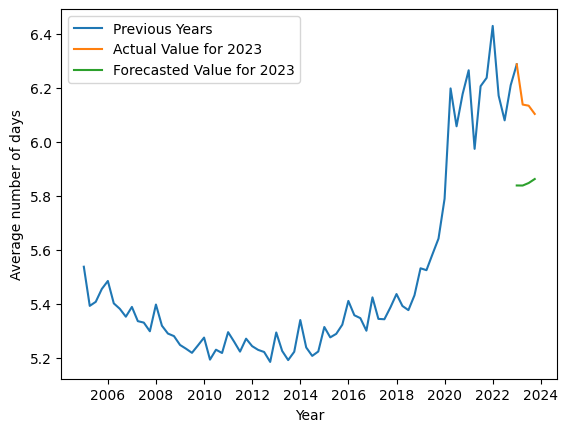

In [44]:
plt.plot(res.iloc[:73], label='Previous Years')
plt.plot(res.iloc[72:], label='Actual Value for 2023')
plt.plot(sampl, label='Forecasted Value for 2023')
plt.xlabel('Year', fontsize=10)
plt.ylabel('Average number of days', fontsize=10)
plt.legend()
plt.show()

##### <font color='green'> The above graph seems unusual as the forecasting value doesn't seem to align with the original value or come any closer to that. So, we will try to employ more advanced timeseries techniques like ARIMA, SARIMA, etc. </font>

## __Conclusion__

- The analysis reveals a significant decline in **Total Discharges** and **Inpatient Days** during 2020 due to lockdowns, followed by a sharp increase post-lockdown, likely attributable to the COVID-19 pandemic

- The **Average Length of Stay (ALOS)** spiked during this period, indicating that patients required longer hospital stays, possibly due to the severity of COVID-19 cases and strained healthcare resources

- The data exhibits clear **seasonal patterns**, with peaks in patient admissions typically occurring in the **first (Q1) and last (Q4) quarters** of the year. These trends align with the prevalence of seasonal diseases such as influenza, RSV, common cold etc during fall and winter months, leading to increased hospitalizations

- The seasonality graph demonstrated a consistent and repetitive pattern over time, confirming the presence of predictable seasonal trends in ALOS data

- The decomposition of the ALOS data successfully captured underlying patterns, as evidenced by the **random residuals** in the residual plot. This confirms the effectiveness of the decomposition process in isolating trend, seasonality, and residual components

- Forecasted **ALOS** for 2023:  
   Using seasonal indexing followed by **linear regression model**, the forecasted ALOS for 2023 is as follows:  
   - **Q1 (January)**: 5.84 days  
   - **Q2 (April)**: 5.84 days  
   - **Q3 (July)**: 5.85 days  
   - **Q4 (October)**: 5.86 days  
   The model achieved a **Mean Squared Error (MSE) of 0.1078**, indicating strong predictive accuracy

- **Implications for Healthcare Management**:  
   - The findings highlight the importance of seasonal preparedness for hospitals, particularly during Q1 and Q4, to manage increased patient admissions effectively
   - The forecasted ALOS values can aid in capacity planning, resource allocation, and staffing optimization to ensure operational efficiency and high quality patient care

* It is necessary for the healthcare providers to track ALOS to keep track on patient flow, as the timeline of the seasonal disease can change if there is a change in climate, which is easy to track when we have required data.
* Additional information like demographics, medical conditions, vaccination rates, public health policies, disease outbreaks, etc; can enhance the model's predictive power.

In this project, we have utilized two datasets, which contain historical Inpatient data and Total Discharge data from US hospitals extracted from FRED who have taken medical insurance from XYZ company. The dataset includes metrics such as:
